<a href="https://colab.research.google.com/github/atik666/AugmmentationCode/blob/TransferLearning/res50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
from tensorflow import keras
from keras.preprocessing.image import load_img, ImageDataGenerator, img_to_array
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from matplotlib import pyplot as plt

In [5]:
from google.colab import drive
drive.mount("/content/drive") 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import numpy as np
X_train1 = np.load("/content/drive/MyDrive/Colab/X_train1.npy")
y_train1 = np.load("/content/drive/MyDrive/Colab/y_train1.npy")
X_val = np.load("/content/drive/MyDrive/Colab/X_val.npy")
y_val = np.load("/content/drive/MyDrive/Colab/y_val.npy")
X_test = np.load("/content/drive/MyDrive/Colab/X_test.npy")
y_test = np.load("/content/drive/MyDrive/Colab/y_test.npy")

In [8]:
datagen = ImageDataGenerator(
    horizontal_flip = True,
    vertical_flip = True,
    width_shift_range=0.5,
    height_shift_range=0.5,
    rotation_range=90,
    brightness_range=[0.5,1.5],
    zoom_range=0.5,
    shear_range=45) # Aug condition
datagen.fit(X_train1)


In [9]:
aug_data = []
aug_label = []
num_aug = 0
for X_batch, y_batch in datagen.flow(X_train1, y_train1, batch_size=100, shuffle=False):
    aug_data.append(X_batch)
    aug_label.append(y_batch)
    num_aug += 100
    if num_aug == 1*X_train1.shape[0]:
        break
X_train2 = np.concatenate(aug_data) 
y_train2 = np.concatenate(aug_label)

X_train = np.concatenate((X_train1, X_train2))
y_train = np.concatenate((y_train1, y_train2))

In [7]:
print('Number of images in X_train', X_train.shape[0])
print('Number of images in X_val', X_val.shape[0])
print('Number of images in X_test', X_test.shape[0])

Number of images in X_train1 1000
Number of images in X_val 500
Number of images in X_test 500


In [10]:
IMAGE_SHAPE = (224, 224, 3)
      
model_name = "mobilenet_v2"
feature_extractor_model="https://tfhub.dev/google/tf2-preview/%s/feature_vector/4" %model_name

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=IMAGE_SHAPE, trainable=False)
       
num_class = 10

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 10)                12810     
Total params: 2,270,794
Trainable params: 12,810
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/50
63/63 [==============================] - 37s 72ms/step - loss: 1.9560 - accuracy: 0.3565 - val_loss: 0.8521 - val_accuracy: 0.8400
Epoch 2/50
63/63 [==============================] - 3s 50ms/step - loss: 1.4166 - accuracy: 0.5485 - val_loss: 0.5193 - val_accuracy: 0.9300
Epoch 3/50
63/63 [==============================] - 3s 50ms/step - loss: 1.2511 - accuracy: 0.5990 - val_loss: 0.3867 - val_accuracy: 0.9540
Epoch 4/50
63/63 [==============================] - 3s 50ms/step - loss: 1.1229

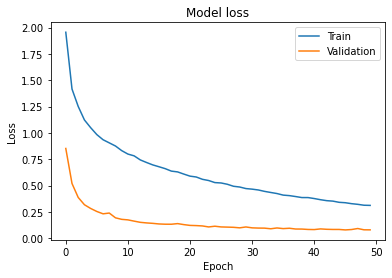

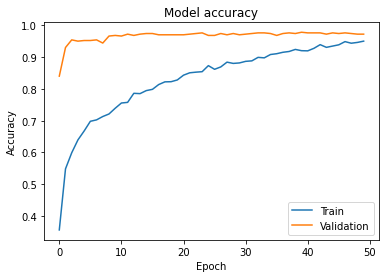

[[50  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0]
 [ 0  0 49  0  0  0  1  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0 48  0  0  0  2]
 [ 0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  3 46  1]
 [ 0  0  0  0  0  0  0  2  1 47]]
acc :  98.0


In [11]:
model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_class)
])

model.summary()          
         
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
     
# Train your model using the early stopping callback
h_callback = model.fit(X_train, y_train, batch_size = 32,
           epochs = 50, validation_data = (X_val, y_val))

loss, acc= model.evaluate(X_test, y_test)
print('Test Accuracy: %f' % (acc*100))

def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper right')
  plt.show()
  
def plot_accuracy(acc,val_acc):
  # Plot training & validation accuracy values
  plt.figure()
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='lower right')
  plt.show()
  
# Plot train vs test loss during training
plot_loss(h_callback.history['loss'], h_callback.history['val_loss'])

# Plot train vs test accuracy during training
plot_accuracy(h_callback.history['accuracy'], h_callback.history['val_accuracy'])

from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
conf = confusion_matrix(y_test, y_pred)
print(conf)
print('acc : ', np.trace(conf)/np.sum(conf)*100)